In [1]:
%matplotlib inline

import numpy as np
import random
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Neural Networks for SP500

In [2]:
# Download financial data:
import yfinance
from datetime import datetime

myData = yfinance.download(["SPY"],datetime(2010,1,1),datetime(2021,12,31))
SPY = myData["Adj Close"]

r = np.log(SPY) - np.log(SPY.shift(1)) # Daily log return
r = r.to_numpy()
r = np.delete(r , 0) # Remove first date because 1 lag in returns

train_X = r[0:2500]
test_X = r[2500:3018]
train_y = r[1:2501]
test_y = r[2501:3019]

[*********************100%***********************]  1 of 1 completed


### Linear Regression as baseline model

In [3]:
# How does this compare with an AR(1) model
XX = np.vstack([np.ones(len(train_X)),train_X]).T
b0,b1 = np.linalg.lstsq(XX,train_y,rcond=None)[0]

# Compute MSE
print(np.mean(((b0+b1*test_X) - test_y)**2))

0.00024619567357333637


### Feed-Forward Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


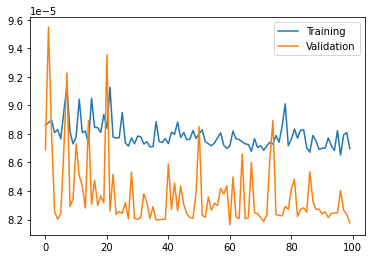

8.696631266502663e-05
8.17676045699045e-05
0.00023635130492039025


In [4]:
# Construct neural network
HIDDEN = 16
NN =keras.Sequential()
NN.add(keras.layers.Dense(HIDDEN, input_dim=1,activation='relu')) #1 input x
NN.add(keras.layers.Dense(HIDDEN, activation='relu'))
NN.add(keras.layers.Dense(1, activation='linear')) #1 output y

NN.summary()

# State the loss function and optimizer (adam is a good choice usually)
NN.compile(optimizer=keras.optimizers.Adam(),loss='mean_squared_error')

# Fit the model to training data
EPOCHS = 100 # How long to train for (cut off early)
history = NN.fit(train_X,train_y,epochs=EPOCHS,validation_split=0.1,verbose=0)
# View improvement over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.show()
print(history.history['loss'][-1]) # Training MSE
print(history.history['val_loss'][-1]) # Validation loss

# Evaluate on test data
print(NN.evaluate(test_X , test_y , verbose=0)) # Test MSE

### Time-Dilation Neural Network

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 16)             48        
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             528       
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


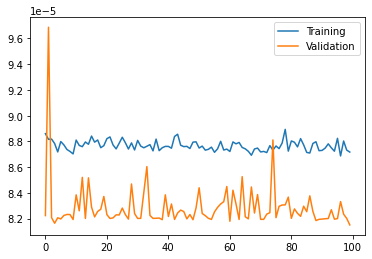

8.717106538824737e-05
8.151055953931063e-05
0.0002417645009700209


In [6]:
# Construct neural network
# Need to reshape for use in CNN
train_X = train_X.reshape(train_X.shape[0],1,1)
test_X = test_X.reshape(test_X.shape[0],1,1)

HIDDEN = 16
TDNN = keras.Sequential()
TDNN.add(keras.layers.Input(shape=(1,1))) #COMMENT ON SHAPE
# Add 1D convolution layers
# First 2 inputs are the filters (i.e., output size) and kernel_size (i.e., length of the convolution window)
# padding='causal' means that information follows the temporal direction (no using future information)
TDNN.add(keras.layers.Conv1D(filters=HIDDEN, kernel_size=2, padding='causal', dilation_rate=2, activation='relu'))
TDNN.add(keras.layers.Conv1D(filters=HIDDEN, kernel_size=2, padding='causal', dilation_rate=1, activation='relu'))
TDNN.add(keras.layers.Flatten())
TDNN.add(keras.layers.Dense(1, activation='linear')) #1 output y

TDNN.summary()

# State the loss function and optimizer (adam is a good choice usually)
TDNN.compile(optimizer=keras.optimizers.Adam(),loss='mean_squared_error')

# Fit the model to training data
EPOCHS = 100 # How long to train for (cut off early)
history = TDNN.fit(train_X,train_y,epochs=EPOCHS,validation_split=0.1,verbose=0)
# View improvement over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.show()
print(history.history['loss'][-1]) # Training MSE
print(history.history['val_loss'][-1]) # Validation loss

# Evaluate on test data
print(TDNN.evaluate(test_X , test_y , verbose=0)) # Test MSE